In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Vishal\AppData\Local\Temp\ipykernel_24836\1545144777.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#Convert MNIST image files into a tensor of 4-D (no.of images, height, width, color channels)
transform = transforms.ToTensor()

In [3]:
# Train data
train_data = datasets.MNIST(root='', train=True, download=True, transform=transform) 

In [4]:
# Test data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform) 

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
# Create small batch size
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(train_data, batch_size=10, shuffle=False)

In [8]:
# Define our CNN
conv1 = nn.Conv2d(1, 6, 3, 1) #input, output/featureMap, kernel_size, stride
conv2 = nn.Conv2d(6, 16, 3, 1)

In [9]:
# Grab 1 MNIST record
for i, (X_Train, y_train) in enumerate(train_data):
    break

In [10]:
X_Train.shape   # 1 image, 28x28 size

torch.Size([1, 28, 28])

In [11]:
#4-d
x = X_Train.view(1,1,28,28) # 1 batch of 1 image of 28x28 size

In [12]:
# Perform our first convolution
x = F.relu(conv1(x)) # Rectified linear unit for activaton function

In [13]:
x.shape

torch.Size([1, 6, 26, 26])

In [14]:
# Pass thru polling layer
x = F.max_pool2d(x, 2, 2) # kernel of 2x2 and stride of 2

In [15]:
x.shape # 26/2 = 13

torch.Size([1, 6, 13, 13])

In [16]:
# 2nd convolutional layer
x = F.relu(conv2(x))

In [17]:
x.shape # again we didnt set padding, we lose 2px around the image

torch.Size([1, 16, 11, 11])

In [18]:
x = F.max_pool2d(x, 2, 2)

In [19]:
x.shape

torch.Size([1, 16, 5, 5])

In [20]:
# Model class
class convolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
       
        # Fully connected layer
        self.fc1 = nn.Linear(5*5*16 ,120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        # Second pass
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        
        # Re-view to flatten it out
        X = X.view(-1, 5*5*16) # negative 1, so that we can vary batch size
        
        # Fully connected layer
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)
        
        

In [21]:
# Create an instance of our model
torch.manual_seed(41)
model = convolutionalNetwork()
model

convolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [22]:
# Loss functionn optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Smaller the Learning Rate, longer its gonna take to train.

In [27]:
import time
start_time = time.time()
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b,(X_train, y_train) in enumerate(train_loader):
        b+=1
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted==y_train).sum()
        trn_corr += batch_corr # keep track as we go along in training.
        
        # Update our parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print out some results
        if b%600 == 0:
            print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Test
    with torch.no_grad(): #No gradient so we don't update our weights and biases with test data
        for b,(X_test, y_test) in enumerate(train_loader):
          y_val = model(X_test)
          predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
          tst_corr += (predicted == y_test).sum() # T=1 F=0 and sum away
    
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)






current_time = time.time()
total_time = current_time - start_time
print(f"Training took {total_time/60} minutes!")

Epoch: 0  Batch: 600  Loss: 0.1623609960079193
Epoch: 0  Batch: 1200  Loss: 0.16026657819747925
Epoch: 0  Batch: 1800  Loss: 0.49889492988586426
Epoch: 0  Batch: 2400  Loss: 0.11830595880746841
Epoch: 0  Batch: 3000  Loss: 0.0061146290972828865
Epoch: 0  Batch: 3600  Loss: 0.238155797123909
Epoch: 0  Batch: 4200  Loss: 0.003644376527518034
Epoch: 0  Batch: 4800  Loss: 0.0021698237396776676
Epoch: 0  Batch: 5400  Loss: 0.07755373418331146
Epoch: 0  Batch: 6000  Loss: 0.0002884259447455406
Epoch: 1  Batch: 600  Loss: 0.026902830228209496
Epoch: 1  Batch: 1200  Loss: 0.008197079412639141
Epoch: 1  Batch: 1800  Loss: 0.0019051560666412115
Epoch: 1  Batch: 2400  Loss: 0.004397055599838495
Epoch: 1  Batch: 3000  Loss: 0.00010866493539651856
Epoch: 1  Batch: 3600  Loss: 0.004198158625513315
Epoch: 1  Batch: 4200  Loss: 0.0005931697087362409
Epoch: 1  Batch: 4800  Loss: 0.009555033408105373
Epoch: 1  Batch: 5400  Loss: 0.00034579209750518203
Epoch: 1  Batch: 6000  Loss: 0.0003026198537554592
E

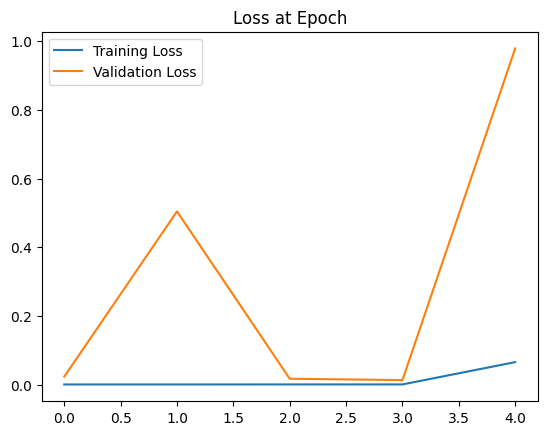

In [28]:
# Graph the loss at epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()  

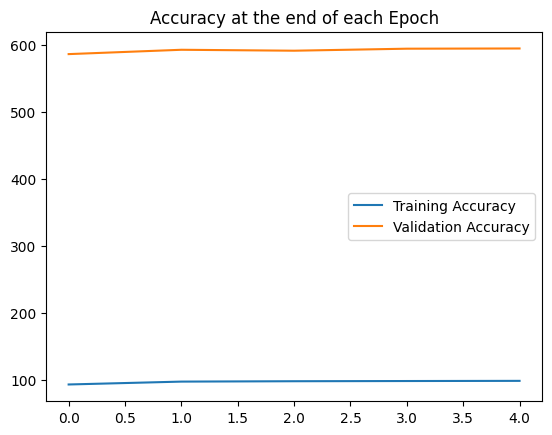

In [29]:
# graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()
     